# Neural Ordinary Differential Equation

In [1]:
# Import packages
import numpy as np
import torch
import torchdiffeq
import plotly.graph_objects as go
from nn import *

In [12]:
# Function representing derivative
def func(t, x):
    return x

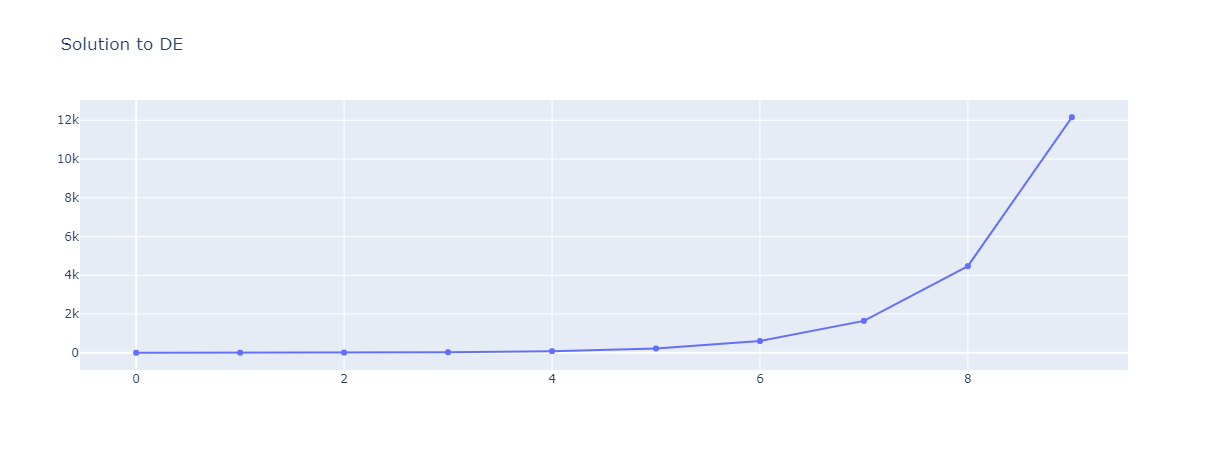

In [19]:
# Initial condition
y0 = torch.ones(1) * 1.5

# Times to evaluate
t = torch.Tensor(np.arange(10))

# Solve differential equation
x = odeint(func, y0, t)

# Plot solution
go.Figure(data=go.Scatter(x=t, y=x[:, 0]), layout=dict(title="Solution to DE")).show()

Modify this code to learn a simple one-D function like the other notebooks.

In [30]:
# Import libraries
import torch.nn as nn
import torch.optim as optim

# Set parameters
method = 'dopri5'
data_size = 1000
batch_time = 10
batch_size = 20
niters = 100
test_freq = 20
gpu = 0
adjoint = True

# Import ODE integrator depending on whether adjoint is set to true
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

# Specify GPU if available, CPU otherwise
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')

# Initial (two-D) value, times for evaluation of solution, and a matrix 
# defining the spiral gradient
true_y0 = torch.tensor([[2., 0.]]).to(device)
t = torch.linspace(0., 25., data_size).to(device)
true_A = torch.tensor([[-0.1, 2.0], [-2.0, -0.1]]).to(device)

# Lambda class extending a neural network module by defining a function 
# forward that returns a matrix multiply of the cube of a vector y and a matrix A
class Lambda(nn.Module):
    def forward(self, t, y):
        return torch.mm(y**3, true_A)

# Find true solution to differential equation
with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, t, method='dopri5')

# Create batch of samples of initial values, times, and true trajectories
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[:batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

# Class extending nn module with a two-layer net, tanh on the hidden, 
# initialising the weights, and a forward function that takes the cube of y and
# passes it through the net.
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 2),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y**3)

# Pass function to GPU, attache optimiser
func = ODEFunc().to(device)
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)

# Loop over iterations using the differential equation solver (integrator) to
# predict the output from the neural network derivative function, getting the loss, and
# back-propogating the gradient through the ODE solver to the neural net - 
# that's all there is to it
for itr in range(1,  niters + 1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint(func, batch_y0, batch_t).to(device)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    if itr %  test_freq == 0:
        with torch.no_grad():
            pred_y = odeint(func, true_y0, t)
            loss = torch.mean(torch.abs(pred_y - true_y))
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))

Iter 0020 | Total Loss 0.710318
Iter 0040 | Total Loss 0.554677
Iter 0060 | Total Loss 0.432260
Iter 0080 | Total Loss 0.738078
Iter 0100 | Total Loss 0.512062


In [30]:
# Import libraries
import time
import torch.nn as nn
import torch.optim as optim

# Set parameters
method = 'dopri5'
data_size = 1000
batch_time = 10
batch_size = 20
niters = 100
test_freq = 20
gpu = 0
adjoint = True

# Import ODE integrator depending on whether adjoint is set to true
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

# Specify GPU if available, CPU otherwise
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')

# Initial (two-D) value, times for evaluation of solution, and a matrix 
# defining the spiral gradient
true_y0 = torch.tensor([[2., 0.]]).to(device)
t = torch.linspace(0., 25., data_size).to(device)
true_A = torch.tensor([[-0.1, 2.0], [-2.0, -0.1]]).to(device)

# Lambda class extending a neural network module by defining a function 
# forward that returns a matrix multiply of the cube of a vector y and a matrix A
class Lambda(nn.Module):
    def forward(self, t, y):
        return torch.mm(y**3, true_A)

# Find true solution to differential equation
with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, t, method='dopri5')

# Create batch of samples of initial values, times, and true trajectories
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[:batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

# Class extending nn module with a two-layer net, tanh on the hidden, 
# initialising the weights, and a forward function that takes the cube of y and
# passes it through the net.
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 2),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y**3)

# Pass function to GPU, attache optimiser
func = ODEFunc().to(device)
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)

# Loop over iterations using the differential equation solver (integrator) to
# predict the output from the neural network derivative function, getting the loss, and
# back-propogating the gradient through the ODE solver to the neural net - 
# that's all there is to it
for itr in range(1,  niters + 1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint(func, batch_y0, batch_t).to(device)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    if itr %  test_freq == 0:
        with torch.no_grad():
            pred_y = odeint(func, true_y0, t)
            loss = torch.mean(torch.abs(pred_y - true_y))
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))

Iter 0020 | Total Loss 0.710318
Iter 0040 | Total Loss 0.554677
Iter 0060 | Total Loss 0.432260
Iter 0080 | Total Loss 0.738078
Iter 0100 | Total Loss 0.512062
